# Problem 2 - Transfer learning: Shallow learning vs Finetuning, Pytorch

## 2.1

### 2.1 (a)

In [1]:
import tarfile
import os
import torch
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from collections import Counter
import pandas as pd
import torchvision.models as models
import torch.nn as nn

# Path to the .tar file
path = 'vgg-flowers.tar'

# Extract the .tar file
if not os.path.exists('vgg-flowers'):
    with tarfile.open(path) as tar:
        tar.extractall()

In [2]:
# Define the transformation
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
# Load the training data from folder
train_dataset = datasets.ImageFolder(root='vgg-flowers/train', transform=transform)
val_dataset = datasets.ImageFolder(root='vgg-flowers/val', transform=transform)

# Create the data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Get the number of classes
num_classes = len(train_dataset.classes)
print(f"Number of classes: {num_classes}")

# Get the distribution of classes in the training dataset
class_counts = Counter([train_dataset.targets[i] for i in range(len(train_dataset.targets))])
class_distribution = {train_dataset.classes[idx]: count for idx, count in class_counts.items()}

# Display the class distribution as a pandas DataFrame
df_distribution = pd.DataFrame.from_dict(class_distribution, orient='index', columns=['Number of Images'])
df_distribution.describe()

Number of classes: 102


,Number of Images
count,102.0
mean,10.0
std,0.0
min,10.0
25%,10.0
50%,10.0
75%,10.0
max,10.0


In summary, target dataset is perfectly balanced with an equal number of images in each class, which is ideal for training a classification model because it avoids class imbalance issues. Such balance ensures that during training, the model does not become biased towards any particular class due to differing amounts of training data.

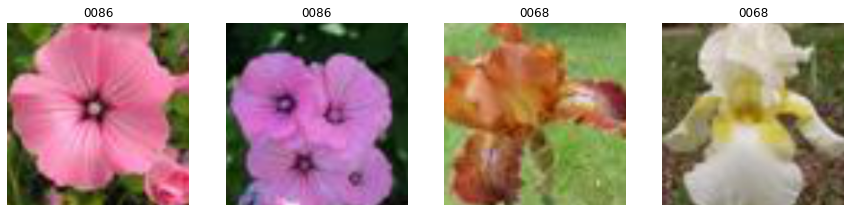

In [3]:
# Set up the mean and std deviation for normalization
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

# Function to denormalize and show images
def show_images(images, titles):
    fig, axes = plt.subplots(1, len(images), figsize=(15, 7))
    for ax, img, title in zip(axes, images, titles):
        img = img.numpy().transpose((1, 2, 0)) * std + mean  # Denormalize
        img = np.clip(img, 0, 1)
        ax.imshow(img)
        ax.set_title(title)
        ax.axis('off')
    plt.show()

# Retrieve 2 classes randomly
classes_to_display = torch.randperm(num_classes)[:2]

# Retrieve 2 images from each of the selected classes
images_to_display = []
titles_to_display = []

for class_idx in classes_to_display:
    # Indices for all images in the current class
    class_indices = (torch.tensor(train_dataset.targets) == class_idx).nonzero(as_tuple=False).view(-1)
    # Choose 2 images randomly from the class
    images_indices = torch.randperm(len(class_indices))[:2]
    for img_idx in images_indices:
        img, _ = train_dataset[class_indices[img_idx]]
        images_to_display.append(img)
        titles_to_display.append(train_dataset.classes[class_idx])

# Show images
show_images(images_to_display, titles_to_display)

### 2.1 (b)

In [4]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet50
from torch.optim.lr_scheduler import MultiStepLR


# Load the pre-trained ResNet-50 model
model = resnet50(pretrained=True)

# Modify the final fully connected layer
model.fc = nn.Linear(model.fc.in_features, 102)

# Move the model to the GPU 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Define the learning rate scheduler
scheduler = MultiStepLR(optimizer, milestones=[15, 30, 45], gamma=0.1)


# Initialize lists to store per-epoch loss and accuracy values
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Training loop
for epoch in range(60):
    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation phase
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss = running_loss / len(val_loader)
    val_accuracy = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    scheduler.step()
    
    # Print statistics
    print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Train Accuracy: {train_accuracy}%, '
          f'Val Loss: {val_loss}, Val Accuracy: {val_accuracy}%')

print('Finished Training')


/home/gha2009/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gha2009/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Train Loss: 4.65925145149231, Train Accuracy: 1.4705882352941178%, Val Loss: 4.592808544635773, Val Accuracy: 1.9607843137254901%
Epoch 2, Train Loss: 4.492817163467407, Train Accuracy: 5.098039215686274%, Val Loss: 4.474026262760162, Val Accuracy: 6.176470588235294%
Epoch 3, Train Loss: 4.295326381921768, Train Accuracy: 19.11764705882353%, Val Loss: 4.328061372041702, Val Accuracy: 17.45098039215686%
Epoch 4, Train Loss: 4.063928946852684, Train Accuracy: 40.490196078431374%, Val Loss: 4.16943596303463, Val Accuracy: 23.627450980392158%
Epoch 5, Train Loss: 3.8259178698062897, Train Accuracy: 57.05882352941177%, Val Loss: 3.972179129719734, Val Accuracy: 30.980392156862745%
Epoch 6, Train Loss: 3.5539515614509583, Train Accuracy: 67.3529411764706%, Val Loss: 3.7818706333637238, Val Accuracy: 36.27450980392157%
Epoch 7, Train Loss: 3.28289033472538, Train Accuracy: 72.45098039215686%, Val Loss: 3.5442490726709366, Val Accuracy: 39.80392156862745%
Epoch 8, Train Loss: 3.021200

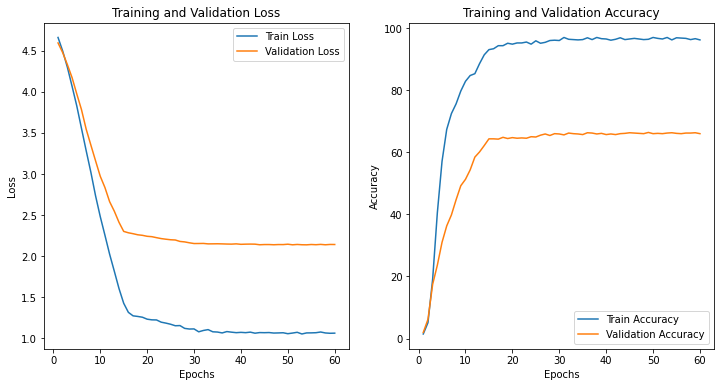

In [5]:
# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, 61), train_losses, label='Train Loss')
plt.plot(range(1, 61), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, 61), train_accuracies, label='Train Accuracy')
plt.plot(range(1, 61), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

* As we progressed through the epochs, we observ a decline in both the training and validation losses, alongside an improvement in the training and validation accuracies. Nonetheless, it is evident that the training loss decreases significantly more than the validation loss, and the training accuracy climbs much higher than the validation accuracy. 
* Although it is normal for the training set to exhibit a higher accuracy because the model is being trained on this data, the substantial gap we see here suggests that overfitting is likely occurring, as the model shows nearly perfect accuracy on the training data but achieves only about 66% accuracy on the validation data. 
* Additionally, it appears that continuing training for the full 60 epochs may not be efficient in terms of time and computational resources, considering that after the initial learning rate reduction at around 15 epochs, there is only a slight increase in model accuracy and a slight decrease in model loss.

### 2.1 (c)

In [6]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet50
from torch.optim.lr_scheduler import MultiStepLR


# Load the pre-trained ResNet-50 model
model = resnet50(pretrained=True)

# Modify the final fully connected layer
model.fc = nn.Linear(model.fc.in_features, 102)

# Move the model to the GPU 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

# Define the learning rate scheduler
scheduler = MultiStepLR(optimizer, milestones=[15, 30, 45], gamma=0.1)


# Initialize lists to store per-epoch loss and accuracy values
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Training loop
for epoch in range(60):
    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation phase
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss = running_loss / len(val_loader)
    val_accuracy = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    scheduler.step()
    
    # Print statistics
    print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Train Accuracy: {train_accuracy}%, '
          f'Val Loss: {val_loss}, Val Accuracy: {val_accuracy}%')

print('Finished Training')


Epoch 1, Train Loss: 4.891782641410828, Train Accuracy: 6.2745098039215685%, Val Loss: 1571507.87109375, Val Accuracy: 0.9803921568627451%
Epoch 2, Train Loss: 5.266057729721069, Train Accuracy: 1.4705882352941178%, Val Loss: 240085.4052734375, Val Accuracy: 0.9803921568627451%
Epoch 3, Train Loss: 4.447994560003281, Train Accuracy: 2.450980392156863%, Val Loss: 221.48749029636383, Val Accuracy: 1.9607843137254901%
Epoch 4, Train Loss: 4.313097968697548, Train Accuracy: 3.627450980392157%, Val Loss: 5.063885673880577, Val Accuracy: 3.0392156862745097%
Epoch 5, Train Loss: 4.145944461226463, Train Accuracy: 3.823529411764706%, Val Loss: 4.214882805943489, Val Accuracy: 6.2745098039215685%
Epoch 6, Train Loss: 3.978504866361618, Train Accuracy: 5.490196078431373%, Val Loss: 3.9409897476434708, Val Accuracy: 7.9411764705882355%
Epoch 7, Train Loss: 3.8111439049243927, Train Accuracy: 5.980392156862745%, Val Loss: 4.032109081745148, Val Accuracy: 7.254901960784314%
Epoch 8, Train Loss: 3.7

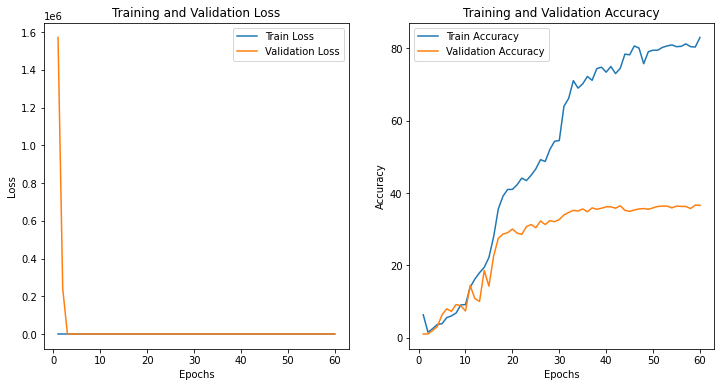

In [7]:
# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, 61), train_losses, label='Train Loss')
plt.plot(range(1, 61), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, 61), train_accuracies, label='Train Accuracy')
plt.plot(range(1, 61), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

* Both the training and validation loss decrease sharply initially, but the validation loss plateaus quickly, staying relatively constant despite further training. On the other hand, the training and validation accuracy shows a steady increase in training accuracy over time, indicating the model is learning from the training data. However, the validation accuracy increases at a much slower rate, showing less pronounced improvement as epochs increase. 
* This discrepancy suggests that the model might be overfitting to the training data, as evidenced by the high training accuracy compared to the lower validation accuracy. Overfitting is a condition where the model performs well on the training data but does not generalize well to unseen data. It is apparent that after a certain point, additional training does not result in significant gains in validation performance, indicating a convergence of the model's learning capability.
* Looking at the graph of accuracies, we can observe that both the training and validation lines do not achieve a "smooth" increase. The slight dip at around 15 epochs (a possible cause to our scheduled decay) indicates that the model is most likely overfitting since training accuracy is relatively high while validation accuracy at the end of the training is around 36.57%. 

In [9]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet50
from torch.optim.lr_scheduler import MultiStepLR


# Load the pre-trained ResNet-50 model
model = resnet50(pretrained=True)

# Modify the final fully connected layer
model.fc = nn.Linear(model.fc.in_features, 102)

# Move the model to the GPU 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Define the learning rate scheduler
scheduler = MultiStepLR(optimizer, milestones=[15, 30, 45], gamma=0.1)


# Initialize lists to store per-epoch loss and accuracy values
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Training loop
for epoch in range(60):
    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation phase
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss = running_loss / len(val_loader)
    val_accuracy = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    scheduler.step()
    
    # Print statistics
    print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Train Accuracy: {train_accuracy}%, '
          f'Val Loss: {val_loss}, Val Accuracy: {val_accuracy}%')

print('Finished Training')


Epoch 1, Train Loss: 4.557856023311615, Train Accuracy: 4.313725490196078%, Val Loss: 3.991536244750023, Val Accuracy: 17.352941176470587%
Epoch 2, Train Loss: 3.1398914456367493, Train Accuracy: 44.11764705882353%, Val Loss: 2.3899622708559036, Val Accuracy: 48.333333333333336%
Epoch 3, Train Loss: 1.5535647943615913, Train Accuracy: 76.96078431372548%, Val Loss: 1.6390562281012535, Val Accuracy: 67.25490196078431%
Epoch 4, Train Loss: 0.6157258041203022, Train Accuracy: 92.25490196078431%, Val Loss: 1.3075620383024216, Val Accuracy: 71.27450980392157%
Epoch 5, Train Loss: 0.19627285655587912, Train Accuracy: 98.43137254901961%, Val Loss: 1.063352782279253, Val Accuracy: 75.88235294117646%
Epoch 6, Train Loss: 0.0680597082246095, Train Accuracy: 99.90196078431373%, Val Loss: 0.9553642924875021, Val Accuracy: 78.62745098039215%
Epoch 7, Train Loss: 0.0356494199950248, Train Accuracy: 100.0%, Val Loss: 0.9060476832091808, Val Accuracy: 79.31372549019608%
Epoch 8, Train Loss: 0.024458896

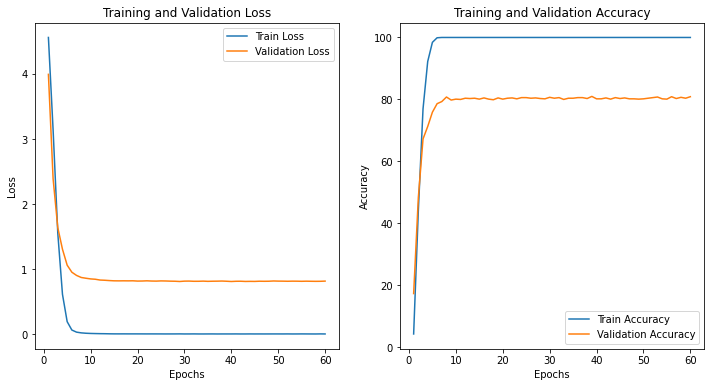

In [10]:
# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, 61), train_losses, label='Train Loss')
plt.plot(range(1, 61), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, 61), train_accuracies, label='Train Accuracy')
plt.plot(range(1, 61), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

* The graph illustrates a rapid decrease in both training and validation loss initially, which then levels off, indicating that the model is learning and improving its predictions. As the epochs progress, the training loss continues to decline slightly, but the validation loss remains flat, suggesting that the model has reached its performance capacity on the validation set.
* The second graph shows the accuracy of the model during the training and validation phases. The training accuracy rapidly approaches near-perfect levels, staying high throughout the remaining epochs. This suggests that the model is very effective at predicting the outcomes of the data it has been trained on. However, the validation accuracy starts low and only improves marginally, plateauing early in the training process. This relatively flat line for validation accuracy, combined with the near-perfect training accuracy, may indicate that the model is overfitting. This indicates that the model has learnt the training data too well, including its noise and outliers, which reduces its ability to perform well on new, unseen data.
* Overall, the graphs suggest that while the model is effectively learning the training data, it is not generalizing as well to new data, as evidenced by the stagnant validation accuracy. This could be an indicator that the model's complexity is too high for the given problem or that the data used for training and validation are not representative of the same distribution.

#### Model Comparison

* Upon evaluating all three models, it is apparent that the model which employs a learning rate of 0.01, outperforms the others by achieving the highest validation accuracy at 80.88%. This is noticeably better than the validation accuracies obtained with the other two models, which are 36.58% for a learning rate of 0.1 and 65.98% for a learning rate of 0.001. 
* From this, we can deduce that the model with a learning rate of 0.01 is the most effective for our specific dataset. It is then followed by the model with a learning rate of 0.001 in which it has a validation accuracy rate of 65.98%. Lastly, the model with the lowest performance has a learning rate of 0.1 and a validation accuracy score of 36.58%.
* The model with a learning rate of 0.01 not only shows a significantly higher accuracy but also requires the same training duration as the others. However, it may be beneficial to consider reducing the number of training epochs, given that the model reached its peak accuracy quite swiftly, which suggests that extending the training with more epochs may be unnecessary.

### 2.2 (a)

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision.models import resnet50
from torchvision import datasets, transforms

# Define the transformation
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
# Load the training data from folder
train_dataset = datasets.ImageFolder(root='vgg-flowers/train', transform=transform)
val_dataset = datasets.ImageFolder(root='vgg-flowers/val', transform=transform)

# Create the data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
# Load the pre-trained ResNet-50 model
model = models.resnet50(pretrained=True)

# Freeze all layers first
for param in model.parameters():
    param.requires_grad = False

# Modify the final fully connected layer to match the number of classes
model.fc = nn.Linear(model.fc.in_features, 102)

# Move the model to the GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# List of learning rates to try
learning_rates = [1, 0.1, 0.01, 0.001]

best_accuracy = 0
best_lr = 0

# Loop over each learning rate
for lr in learning_rates:
    # Define the optimizer - only optimize the final layer's parameters
    optimizer = optim.SGD(model.fc.parameters(), lr=lr, momentum=0.9)
    
    # Define the learning rate scheduler
    scheduler = MultiStepLR(optimizer, milestones=[15, 30, 45], gamma=0.1)
    
    # Store metrics
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    
    # Training loop
    for epoch in range(60):
       # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        
        # Validation phase
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_loss = running_loss / len(val_loader)
        val_accuracy = 100 * correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
    # Step the scheduler
    scheduler.step()
    
    # Print statistics and check best accuracy
    print(f'Epoch {epoch+1}/{60} - LR: {lr}, Train Loss: {train_loss:.4f}, '
          f'Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, '
          f'Val Acc: {val_accuracy:.2f}%')
    
    # Keep track of the best accuracy and learning rate
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_lr = lr

    # Print results for this learning rate
    print(f"Finished training with learning rate: {lr}")
    print(f"Best Validation Accuracy with LR {lr}: {best_accuracy:.2f}%\n")

# Print overall best learning rate and accuracy
print(f"The best learning rate was {best_lr} with an accuracy of {best_accuracy:.2f}%")


/home/gha2009/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gha2009/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 60/60 - LR: 1, Train Loss: 0.0347, Train Acc: 99.80%, Val Loss: 16.3251, Val Acc: 60.98%
Finished training with learning rate: 1
Best Validation Accuracy with LR 1: 60.98%

Epoch 60/60 - LR: 0.1, Train Loss: 0.0000, Train Acc: 100.00%, Val Loss: 15.7231, Val Acc: 61.86%
Finished training with learning rate: 0.1
Best Validation Accuracy with LR 0.1: 61.86%

Epoch 60/60 - LR: 0.01, Train Loss: 0.0000, Train Acc: 100.00%, Val Loss: 15.7362, Val Acc: 62.25%
Finished training with learning rate: 0.01
Best Validation Accuracy with LR 0.01: 62.25%

Epoch 60/60 - LR: 0.001, Train Loss: 0.0000, Train Acc: 100.00%, Val Loss: 15.7645, Val Acc: 61.57%
Finished training with learning rate: 0.001
Best Validation Accuracy with LR 0.001: 62.25%

The best learning rate was 0.01 with an accuracy of 62.25%


### 2.2 (b)

* For the model trained with a learning rate of 1, by the 60th epoch, it had a training loss of 0.0347, indicating the model fits the training data well. The training accuracy was 99.80%, showing nearly perfect performance on the training data. However, the validation loss, which is the measure of error on a separate dataset that the model has not seen during training, was very high at 16.3251. On the other hand, the validation accuracy was 60.98%, which is significantly lower than the training accuracy, indicating overfitting. In other words, this means that the model has learned the training data too well, including its noise and inaccuracies.
* The model with a learning rate of 0.1 had a perfect training loss of 0.0000 and a training accuracy of 100%, meaning it fit the training data perfectly. The validation loss was slightly lower than the model with a learning rate of 1 at 15.7231 while the validation accuracy was 61.86%, which is a marginal improvement yet simultaneously, still indicates overfitting.
* With a learning rate of 0.01, the model also achieved a perfect training loss and accuracy. The validation loss was 15.7362, nearly the same as the model with a learning rate 0.1, but the validation accuracy was slightly higher at 62.25%. Although the small difference in validation accuracy suggests that overfitting is still present, the model with a learning rate of 0.01 is the best-performing model among the ones listed. 
* For the learning rate of 0.001, the training loss and accuracy were again perfect. The validation loss was marginally higher at 15.7645, and the validation accuracy was 61.57%, slightly lower than the model with a learning rate of 0.01. 
* While all models achieved perfect training accuracy, their high validation losses and lower validation accuracies indicate they are not generalizing well to unseen data, which is typical of overfitting. All the models require further advancement especially improving generalization to new data, possibly through techniques like regularization or adjusting the complexity of the model.